In [1]:
from functools import wraps
from typing import Dict

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder
import xgboost as xgb

# Prepare data

In [2]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.y = df.y == "yes"

X = df.loc[:, df.columns != "y"]
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## Utility functions

#### Training XGBoost model

In [3]:
from sklearn.pipeline import Pipeline
    
    
class Trainer:
    def __init__(self, X_train, y_train, X_test, y_test, feature_transformer, evaluation_metric, **model_hyperparameters):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.feature_transformer = feature_transformer
        self.xgb = self._get_xgb_model(model_hyperparameters, evaluation_metric)
        
    def fit(self):
        X_train, X_eval, y_train, y_eval = train_test_split(self.X_train, self.y_train, test_size=0.2, random_state=0)
        
        X_train_encoded = self.feature_transformer.fit_transform(X_train)
        X_eval_encoded = self.feature_transformer.transform(X_eval)
        self.xgb.fit(
            X_train_encoded,
            y_train,
            eval_set=[
                (X_train_encoded, y_train),
                (X_eval_encoded, y_eval)
            ]
        )
        
    def get_train_evaluator(self):
        return BinaryClassifierEvaluator(
            self.get_pipeline(),
            self.X_train,
            self.y_train
        )
        
    def get_test_evaluator(self):
        return BinaryClassifierEvaluator(
            self.get_pipeline(),
            self.X_test,
            self.y_test
        )
        
    def get_learning_curves(self):
        if callable(self.xgb.eval_metric):
            evaluation_metric_name = self.xgb.eval_metric.__name__
        else:
            evaluation_metric_name = self.xgb.eval_metric

        evals_results = self.xgb.evals_result()
        return pd.DataFrame(dict(
            train_metric=evals_results["validation_0"][evaluation_metric_name],
            test_metric=evals_results["validation_1"][evaluation_metric_name],
        ))
        
    def get_pipeline(self):
        return Pipeline(steps=[
            *self.feature_transformer.steps,
            ("classifier", self.xgb)
        ])
        
    @staticmethod
    def _get_xgb_model(hyper_parameters, evaluation_metric):
        fixed_hyper_parameters = dict(
            objective="binary:logistic",
            random_state=0,
            n_estimators=1000,
            importance_type="total_gain",
            verbosity=0,
        )

        return xgb.XGBClassifier(
            **fixed_hyper_parameters,
            eval_metric=evaluation_metric,
            **hyper_parameters
        )

#### Feature transformation

In [4]:
def output_dataframe(function):
    @wraps(function)
    def wrapper(*args, **kwargs):
        series = function(*args, **kwargs)
        return pd.DataFrame(series)
    
    return wrapper


class Discretizer(BaseEstimator, TransformerMixin):
    def __init__(self, bins):
        self.bins = bins
        
    def fit(self, X, y=None):
        return self
        
    @output_dataframe
    def transform(self, x: pd.Series):
        self.intervals = pd.cut(x, self.bins, include_lowest=True)
        return self.intervals.cat.codes.rename(x.name)
    
    def set_output(self, *args, **kwarsg):
        pass


def one_hot(transformer):
    return Pipeline(steps=[
        ("transform", transformer),
        ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])


@output_dataframe
def group_categorical_feature(x, groups: Dict):
    element_to_group_mapping = {element: group for group, elements in groups.items() for element in elements}
    return x.map(element_to_group_mapping)


def categorical_grouper(groups: Dict):
    return FunctionTransformer(group_categorical_feature, kw_args=dict(groups=groups))
    

class HighQuantileOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, proportion_to_remove=0.025):
        self.proportion_to_remove = proportion_to_remove

    def fit(self, X, y=None):
        self.max_quantile = X.quantile(1 - self.proportion_to_remove, axis="index")
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(np.where(X < self.max_quantile, X, self.max_quantile), columns=X.columns, index=X.index).astype(float)
    
    def set_output(self, *args, **kwarsg):
        return self
    
    
@output_dataframe
def month_to_index(s: pd.Series):
    return s.replace(dict(
        jan=1,
        feb=2,
        mar=3,
        apr=4,
        may=5,
        jun=6,
        jul=7,
        aug=8,
        sep=9,
        oct=10,
        nov=11,
        dec=12
    ))


feature_transformer = Pipeline(steps=[
    (
        "discretizations and normalizations", 
        ColumnTransformer(transformers=[
            ("age_discretization", Discretizer([df.age.min(), 25, 45, 60, df.age.max()]), "age"),
            ("month to index", FunctionTransformer(month_to_index), "month"),
            (
                "job_grouping", 
                categorical_grouper({
                    "no-job": ["retired", "unemployed", "student"],
                    "white-collar": ["management", "self-employed", "admin", "technician", "unknown", "entrepreneur"] + ["services", "blue-collar", "housemaid"]
                }),
                "job"
            ),
            ("payroll days", categorical_grouper({1: [1, 2, 30, 31], 0: range(3, 30)}), "day"),
            (
                "quantile transformer to numerical fields",
                HighQuantileOutlierClipper(0.025),
                ("duration", "balance", "campaign")
            )
        ], remainder="passthrough", verbose_feature_names_out=False)
    ),
    (
        "categorical to numeric",
        ColumnTransformer(transformers=[
            (
                "categorical to numerical",
                OrdinalEncoder(),
                df.select_dtypes(include=['object']).columns
            )
        ], remainder="passthrough", verbose_feature_names_out=False)
    ),
    ("one hot", ColumnTransformer(transformers=[
        (
            "one hot",
            OneHotEncoder(handle_unknown='ignore', sparse_output=False),
            [column for column in X.columns if column not in ("duration", "balance", "campaign", "month")]
        )
    ], remainder="passthrough", verbose_feature_names_out=False))
]).set_output(transform="pandas")


c:\users\chana\pythonvirtualenvironments\apziva\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:340: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


# Training

In [5]:
trainer = Trainer(X_train, y_train, X_test, y_test, feature_transformer, "logloss", early_stopping_rounds=50)
trainer.fit()

[0]	validation_0-logloss:0.48340	validation_1-logloss:0.48362
[1]	validation_0-logloss:0.36790	validation_1-logloss:0.36903
[2]	validation_0-logloss:0.29573	validation_1-logloss:0.29802
[3]	validation_0-logloss:0.24785	validation_1-logloss:0.25121
[4]	validation_0-logloss:0.21497	validation_1-logloss:0.21909
[5]	validation_0-logloss:0.19205	validation_1-logloss:0.19754
[6]	validation_0-logloss:0.17538	validation_1-logloss:0.18187
[7]	validation_0-logloss:0.16344	validation_1-logloss:0.17108
[8]	validation_0-logloss:0.15443	validation_1-logloss:0.16274
[9]	validation_0-logloss:0.14714	validation_1-logloss:0.15662
[10]	validation_0-logloss:0.14128	validation_1-logloss:0.15186
[11]	validation_0-logloss:0.13711	validation_1-logloss:0.14903
[12]	validation_0-logloss:0.13368	validation_1-logloss:0.14634
[13]	validation_0-logloss:0.13108	validation_1-logloss:0.14533
[14]	validation_0-logloss:0.12899	validation_1-logloss:0.14361
[15]	validation_0-logloss:0.12700	validation_1-logloss:0.14237
[1

# Model explainability

c:\users\chana\pythonvirtualenvironments\apziva\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\users\chana\pythonvirtualenvironments\apziva\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\users\chana\pythonvirtualenvironments\apziva\Lib\site-packages\shap

  0%|          | 0/60 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


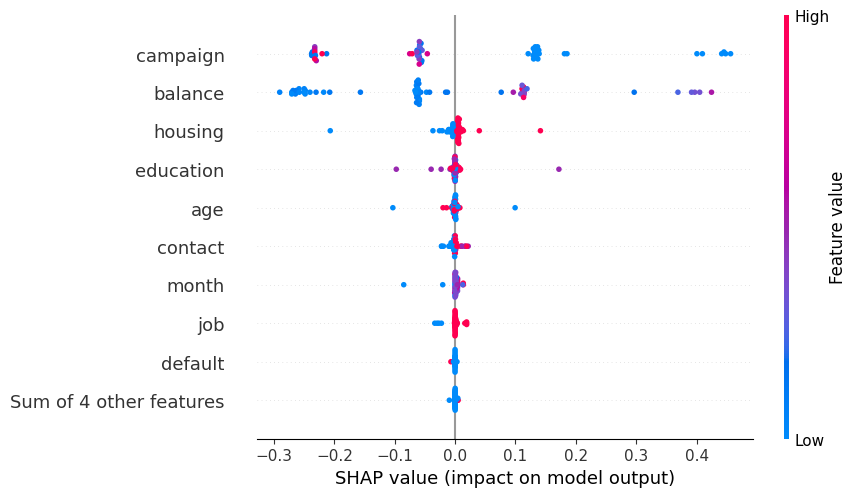

In [6]:
import functools

import shap

class ModelWrapper:
    def __init__(self, model, feature_transformer):
        self.model = model
        self.feature_transformer = feature_transformer
        
    def predict(self, X):
        X = pd.DataFrame(X, columns=X_test.columns)
        X_preprocessed = self.feature_transformer.transform(X)
        return self.model.predict(X_preprocessed)


model_wrapper = ModelWrapper(trainer.xgb, feature_transformer["one hot"])

X_test_preprocessed = feature_transformer[:2].transform(X_test)
X_test_background = shap.utils.sample(X_test_preprocessed, 100)
X_test_sample = shap.utils.sample(X_test_preprocessed, 60)

explainer = shap.KernelExplainer(model_wrapper.predict, X_test_background)
shap_values = explainer.shap_values(X_test_sample)
explanation = shap.Explanation(shap_values, data=X_test_sample, base_values=explainer.expected_value)

shap.plots.beeswarm(explanation)

As we can see, for a sample of 20 clients, the most relevant features seem to be campaign and balance. The lower the number of calls during the marketing campaign, the higher the contribution to the success rate. With the balance happens the other way around.

The rest of variables seem to be pretty irrelevant.